In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm

large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica Neue"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
# plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron, eye, identity
from scipy.sparse.linalg import expm

class NonUnitaryVQE:
     """
     Finds the maximum energy state of a self-consistent mean-field Hamiltonian
     H(x) = x*X - Delta*Z using gradient ascent. This version includes an
     adaptive learning rate to help stabilize convergence to the self-consistent solution.
     """

     # --- Pauli Matrices (Class Attributes) ---
     I2 = csc_matrix(np.eye(2, dtype=complex))
     I4_sparse = identity(4, dtype=complex, format='csc')
     X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
     Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
     Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

     def __init__(self, Delta, gamma_depol, dissipators):
          """
          Initializes the optimizer with system and noise parameters.
          """
          self.Delta = Delta
          self.gamma_depol = gamma_depol
          # If dissipators = True then the dissipative part of the ansatz is used,
          # otherwise identity matrices are used instead.
          self.dissipators = dissipators
          
          self.n_params = 4

          # If dissipation is off, the Lindblad operators are zero matrices.
          self.L1_op = csc_matrix((self.X - 1j * self.Y) / 2) if self.dissipators else csc_matrix((2, 2), dtype=complex)
          self.L2_op = csc_matrix((self.I2.toarray() + self.Z.toarray()) / 2) if self.dissipators else csc_matrix((2, 2), dtype=complex)

          # Depolarizing noise channel superoperator
          self.D_mat = self._get_depolarizing_superop()
          self.D_mat_sparse = csc_matrix(self.D_mat)

          # Storage for results
          self.cost_history = []
          self.gradients_history = []
          self.hessian_diag_history = []            
          self.rho_history = []
          self.x_history = []
          self.y_history = []
          self.z_history = []
          self.best_angles = None
          # Best cost is set at -infinity for maximization
          self.best_cost = -np.inf

     # Function to vectorize and unvectorize density matrices
     @staticmethod
     def _vectorize(rho):
          if hasattr(rho, "toarray"):
               rho = rho.toarray()
          return csc_matrix(rho.flatten(order="F")[:, None])

     @staticmethod
     def _unvectorize(rho_vec):
          rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
          return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

     # Bloch vector from a density matrix
     def _get_bloch_vector(self, rho_mat):
          # Sparse matrices convert to dense for trace calculations
          if hasattr(rho_mat, "toarray"):
               rho_mat = rho_mat.toarray()
          x = np.real(np.trace((self.X @ rho_mat)))
          y = np.real(np.trace((self.Y @ rho_mat)))
          z = np.real(np.trace((self.Z @ rho_mat)))
          return x, y, z

     # Superoperator for depolarizing noise
     def _L_depol_super(self):
          term_x = kron(self.X.conj(), self.X, format='csc')
          term_y = kron(self.Y.conj(), self.Y, format='csc')
          term_z = kron(self.Z.conj(), self.Z, format='csc')
          term_I = kron(self.I2, self.I2, format='csc')
          return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)
     
     def _get_depolarizing_superop(self):
          if abs(self.gamma_depol) < 1e-12:
               return self.I4_sparse
          return expm(self._L_depol_super())

     # Superoperators for mean field term
     def _L_int_ansatz(self, x_mean):
          H_int = x_mean * self.X
          return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))

     # Superoperator for field term
     def _L_f_ansatz(self):
          H_f = -self.Delta * self.Z
          return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

     # Superoperators for excitation jump operator
     def _L_exc_ansatz(self):
          L_op = self.L1_op
          LdL = L_op.conj().T @ L_op
          return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

     # Superoperators for dephasing jump operator
     def _L_dep_ansatz(self):
          L_op = self.L2_op
          LdL = L_op.conj().T @ L_op
          return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

     # Hamiltonian at given x value
     def _get_hamiltonian(self, x_val):
          return x_val * self.X - self.Delta * self.Z

     # Cost function to maximize in VQE
     def _cost_function(self, rho_final_mat, x_final):
          H_final = self._get_hamiltonian(x_final)
          # Sparse matrix is converted to dense for trace calculation
          if hasattr(rho_final_mat, "toarray"):
               rho_final_mat = rho_final_mat.toarray()
          return np.real(np.trace((H_final @ rho_final_mat)))

     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history):
          """ 
          Inputs: n_layers: Number of layers in the circuit
                  evolvers: List of evolution operators for each layer
                  propagators: List of propagators for each layer
                  rho_history: List of density matrices for each layer
                  x_history: List of x values for each layer
          Outputs: grads: List of gradients for each layer and parameter
          """
          grads = [[0.0] * self.n_params for _ in range(n_layers)]
          x_final = x_history[-1]
          H_final = self._get_hamiltonian(x_final)

          # For many layers, we need to backpropagate through the layers
          for l in range(n_layers):
               propagator_after_layer = self.I4_sparse.copy()
               for i in range(l + 1, n_layers):
                    propagator_after_layer = propagators[i] @ propagator_after_layer
               
               # Product of ansatz until layer l (not including layer l)
               rho_before_layer = rho_history[l]

               r""" Chain rule to calculate dC / d\theta
                         dC / d\theta = d/d\theta (Tr[H(x) \rho])
                                      = Tr[(dH/ d\theta) * \rho] + Tr[H * d\rho / d\theta]
                                      = Tr[X (dx/d\theta) * \rho] + Tr[H * d\rho / d\theta]

               The term dx/d\theta is calculated as
               dx/ d\theta = d / d\theta (Tr[X * \rho]) = Tr[X * d\rho / d\theta]

               We need d\rho / d\theta only to compute dC / d\theta
               """
               def compute_gradient_from_drho(d_rho_final_vec):
                    """
                    Inputs: 
                    d_rho_final_vec: derivative of final density matrix vector w.r.t. parameter theta
                    Outputs:
                    Derivative of cost function w.r.t. parameter theta dC/d\theta
                    """
                    d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                    dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
                    term1 = x_final * dx_dtheta # dx / d\theta is a number
                    term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
                    return term1 + term2
               
               # Depolarizing superoperator
               D = self.D_mat_sparse

               # Order in which ansatz is applied: E_f, E_exc, E_int, E_dep (counting from left to right)
               E_f, E_exc, E_int, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]
               
               # Gradient for theta_f (grads[l][0])
               rho_post_f = E_f @ D @ rho_before_layer
               deriv_vec_local = self._L_f_ansatz() @ rho_post_f
               prop_from_f = D @ E_dep @ D @ E_int @ D @ E_exc @ D
               d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
               grads[l][0] = compute_gradient_from_drho(d_rho_final)

               # Gradient for theta_exc (grads[l][1])
               rho_post_exc = E_exc @ D @ E_f @ D @ rho_before_layer
               deriv_vec_local = self._L_exc_ansatz() @ rho_post_exc
               prop_from_exc = D @ E_dep @ D @ E_int @ D
               d_rho_final = propagator_after_layer @ prop_from_exc @ deriv_vec_local
               grads[l][1] = compute_gradient_from_drho(d_rho_final)

               # Gradient for theta_int (grads[l][2])
               # rho_pre_int = D @ E_exc @ D @ E_f @ D @ rho_before_layer
               # x_pre_int, y_pre_int, z_pre_int = self._get_bloch_vector(self._unvectorize(rho_pre_int))
               # deriv_mat_local = x_pre_int * (y_pre_int * self.Z - z_pre_int * self.Y)
               # deriv_vec_local = self._vectorize(deriv_mat_local)

               # x_before_layer_l = x_history[l]
               # rho_after_layer_l = rho_history[l + 1]
               # deriv_vec_local = - 1j * x_before_layer_l * (self.X @ rho_after_layer_l - rho_after_layer_l @ self.X)

               # prop_from_int = D @ E_dep @ D
               # d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
               # grads[l][2] = compute_gradient_from_drho(d_rho_final)

               # --- Gradient for theta_int (grads[l][2]) ---

               # 1) state just BEFORE the X-layer:
               rho_pre_int_vec = D @ E_exc @ D @ rho_before_layer
               rho_pre_int_mat = self._unvectorize(rho_pre_int_vec)
               x_pre_int,_,_   = self._get_bloch_vector(rho_pre_int_mat)  # = 0 if rho_i=(I+Y)/2

               # 2) generator insertion at that point:
               deriv_mat_local = -1j * x_pre_int * (
               self.X @ rho_pre_int_mat
               - rho_pre_int_mat @ self.X
               )
               deriv_vec_local = self._vectorize(deriv_mat_local)

               # 3) push forward through the remaining Z-layer:
               prop_from_int = D @ E_f @ D
               d_rho_final  = propagator_after_layer @ prop_from_int @ deriv_vec_local

               # 4) assemble into the gradient:
               grads[l][2] = compute_gradient_from_drho(d_rho_final)



               
               # Gradient for theta_dep (grads[l][3])
               rho_post_dep = E_dep @ D @ E_int @ D @ E_exc @ D @ E_f @ D @ rho_before_layer
               deriv_vec_local = self._L_dep_ansatz() @ rho_post_dep
               prop_from_dep = D
               d_rho_final = propagator_after_layer @ prop_from_dep @ deriv_vec_local
               grads[l][3] = compute_gradient_from_drho(d_rho_final)

          return grads
     
     def _get_gradients_at_angles(self, n_layers, angles_list, rho_initial_vec):
          _, evolvers, propagators, rho_hist, x_hist, _ = \
               self._variational_ansatz(n_layers, angles_list, rho_initial_vec)
          return self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist)

     def _calculate_hessian_diag(self, n_layers, angles, rho_initial_vec, epsilon=1e-4):
          hessian_diag = [[0.0] * self.n_params for _ in range(n_layers)]
          for l in range(n_layers):
               for k in range(self.n_params):
                    angles_plus = [row[:] for row in angles]
                    angles_plus[l][k] += epsilon
                    grad_plus = self._get_gradients_at_angles(n_layers, angles_plus, rho_initial_vec)
                    angles_minus = [row[:] for row in angles]
                    angles_minus[l][k] -= epsilon
                    grad_minus = self._get_gradients_at_angles(n_layers, angles_minus, rho_initial_vec)
                    hessian_diag[l][k] = (grad_plus[l][k] - grad_minus[l][k]) / (2 * epsilon)
          return hessian_diag     

     def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):

          """
          Inputs:
          n_layers: Number of layers in the ansatz
          angles_list: List of angles for each layer, shape (n_layers, 4)
          rho_initial_vec: Initial density matrix in vectorized form
          Outputs:
          rho_vec: Final density matrix in vectorized form
          evolvers: List of evolution operators E_f, E_exc, E_int, E_dep for each layer
          propagators: List of propagators for each layer
          rho_history: List of density matrices at each layer
          x_history: List of x values at each layer
          """
          rho_vec = rho_initial_vec.copy()
          rho_history = [rho_vec]
          x_history = []
          bloch_history = []
          # This list stores evolution operators for each layer
          # which are required to calculate gradients of cost function
          # New order: E_f, E_exc, E_int, E_dep
          evolvers = ([], [], [], [])
          propagators = []
          D = self.D_mat_sparse

          for i in range(n_layers):
               
               # Angles are stored in the same order as ansatz: f, exc, int, dep (counting from left to right)
               alpha_f, alpha_exc, alpha_int, alpha_dep = angles_list[i]

               # Keep theta_f and theta_int as is
               theta_f = alpha_f
               theta_int = alpha_int

               # Transform alphas to thetas for the dissipative parts to ensure positivity
               theta_exc = np.exp(alpha_exc)
               theta_dep = np.exp(alpha_dep)
               
               # x_current is from the state before this layer's evolution
               rho_current_mat = self._unvectorize(rho_vec)
               x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
               x_history.append(x_current)
               bloch_history.append((x_current, y_current, z_current))
               
               # Calculate operators. E_int uses x_current from *before* the layer.
               E_f   = expm(theta_f   * self._L_f_ansatz())
               E_int = expm(theta_int * self._L_int_ansatz(x_current))
               
               # If dissipators is False, use identity matrices instead of the dissipative ansatz
               if self.dissipators:
                    E_exc = expm(theta_exc * self._L_exc_ansatz())
                    E_dep = expm(theta_dep * self._L_dep_ansatz())
               else:
                    E_exc = self.I4_sparse
                    E_dep = self.I4_sparse
               
               # \rho_{layer i} = D E_dep D E_int D E_exc D E_f D \rho_{layer i-1}
               M = D @ E_dep @ D @ E_int @ D @ E_exc @ D @ E_f @ D

               rho_vec = M @ rho_vec
               
               rho_mat_temp = self._unvectorize(rho_vec)
               trace_val = np.trace(rho_mat_temp.toarray())
               if abs(trace_val) > 1e-12:
                    rho_vec = self._vectorize(rho_mat_temp / trace_val)
               
               # Density matrix after this layer
               rho_history.append(rho_vec)

               # Store evolvers in the new order: f, exc, int, dep
               evolvers[0].append(E_f)
               evolvers[1].append(E_exc)
               evolvers[2].append(E_int)
               evolvers[3].append(E_dep)
               propagators.append(M)

          x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
          x_history.append(x_final)

          return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

     def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, 
                    lr_decay_rate, tolerance, clip_threshold):
          
          expected_params = self.n_params
          for i, layer_angles in enumerate(initial_angles):
               if len(layer_angles) != expected_params:
                    raise ValueError(f"Layer {i}: Expected {expected_params} parameters, got {len(layer_angles)}")
                    
          # # Initial guess for density matrix                  
          # # we start with a known solution with a small perturbation
          # perturbation = 6.0 * 1.e-1
          # rx = np.sqrt(1 - self.Delta ** 2) - perturbation
          # rz = - self.Delta + perturbation
          # if np.abs(1 - rx**2 - rz**2) < 1.e-10:
          #      ry = 0
          # else:
          #      # Component is chosen to ensure normalization
          #      ry = np.sqrt(1 - rx**2 - rz**2)

          # print("Normalization of Bloch vector:", np.sqrt(rx**2 + ry**2 + rz**2))

          # rho_initial_mat = (self.I2.toarray() + rx*self.X.toarray() + ry*self.Y.toarray() + rz*self.Z.toarray())/2
          rho_initial_mat = (self.I2.toarray() + self.Y.toarray())/ 2
          rho_initial_mat /= np.trace(rho_initial_mat)
          rho_initial_vec = self._vectorize(rho_initial_mat)
          
          angles = [list(params) for params in initial_angles]
          self.best_angles = [list(a) for a in angles]
          
          self.cost_history.clear()
          self.gradients_history.clear()
          self.rho_history = []
          self.x_history.clear()
          self.y_history.clear()
          self.z_history.clear()

          # Append the initial state and cost
          self.rho_history.append(rho_initial_mat)
          x_initial, y_initial, z_initial = self._get_bloch_vector(rho_initial_mat)
          initial_cost = self._cost_function(rho_initial_mat, x_initial)

          self.cost_history.append(initial_cost)
          self.x_history.append(x_initial)
          self.y_history.append(y_initial)
          self.z_history.append(z_initial)          

          for iteration in range(max_iterations):
               rho_final_vec, evolvers, propagators, rho_hist, x_hist, _ = \
                    self._variational_ansatz(n_layers, angles, rho_initial_vec)

               rho_final_mat = self._unvectorize(rho_final_vec)
               self.rho_history.append(rho_final_mat)
               x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
               current_cost = self._cost_function(rho_final_mat, x_final)

               self.cost_history.append(current_cost)
               self.x_history.append(x_final)
               self.y_history.append(y_final)
               self.z_history.append(z_final)
               print("Normalization of Bloch vector = ", np.sqrt(x_final**2 + y_final**2 + z_final**2))
               
               if current_cost > self.best_cost:
                    self.best_cost = current_cost
                    self.best_angles = [list(a) for a in angles]

               if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
                    print(f"\nConvergence criterion met at iteration {iteration}!")
                    break
               
               gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist)
               self.gradients_history.append(gradients)

               hessian_diag = self._calculate_hessian_diag(n_layers, angles, rho_initial_vec)
               self.hessian_diag_history.append(hessian_diag)               
               
               grad_norm = np.linalg.norm(np.array(gradients))
               if grad_norm > clip_threshold:
                    gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
               
               for l in range(n_layers):

                    # New angle order: f(0), exc(1), int(2), dep(3)

                    # Exponentials are at indices 1 and 3
                    theta_exc = np.exp(angles[l][1])
                    theta_dep = np.exp(angles[l][3])

                    # Update for theta_f (k=0) is direct
                    angles[l][0] += learning_rate * gradients[l][0]

                    # Update for alpha_exc (k=1) uses the chain rule
                    if self.dissipators:
                         angles[l][1] += learning_rate * gradients[l][1] * theta_exc
                    else:
                         angles[l][1] = 0.0

                    # Update for theta_int (k=2) is direct
                    angles[l][2] += learning_rate * gradients[l][2]

                    # Update for alpha_dep (k=3) uses the chain rule
                    if self.dissipators:
                         angles[l][3] += learning_rate * gradients[l][3] * theta_dep
                    else:
                         angles[l][3] = 0.0
               
               print('Angles after iteration {}: {}'.format(iteration, angles))
               learning_rate *= lr_decay_rate
                    
          return self.best_angles, self.best_cost, self.cost_history, self.rho_history, self.gradients_history, self.hessian_diag_history

Delta = 0.6
gamma_depol = 0.0

learning_rate_dict = {1:0.01, 2: 0.01, 3: 0.01, 4:0.01, 5: 0.005, 6: 0.005 }

if __name__ == '__main__':

     n_layers = 2

     for dissipator in [False, True]:

          dissipators = dissipator
          print(f"Running VQE with {n_layers} layers and dissipators={dissipators}")
          vqe = NonUnitaryVQE(
               Delta=Delta, 
               gamma_depol=gamma_depol,
               dissipators=dissipators
          )
          n_params = vqe.n_params

          # Angle sequence is f, exc, int, dep
          if dissipators:
               initial_angles = [[0.5 * np.random.random(), -10.0, 0.5 * np.random.random(), -10.0] for _ in range(n_layers)]
               print("Initial angles:", initial_angles)
          else:
               initial_angles = [[0.5 * np.random.random(), 0.0, 0.5 * np.random.random(), 0.0] for _ in range(n_layers)]
               print("Initial angles:", initial_angles)

          best_angles, best_cost, cost_history, rho_history, gradients_history, hessian_diag_history = vqe.run_vqa(
               n_layers=n_layers,
               initial_angles=initial_angles,
               learning_rate=learning_rate_dict.get(n_layers),  # Can start with a slightly larger LR now
               max_iterations=500,  # May need more iterations to converge with smaller steps
               lr_decay_rate=1.0,
               tolerance=1e-5,
               clip_threshold=np.inf
          )

          path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/jupyter_data/'
          os.chdir(path)

          result = {
          'best_angles':    best_angles,
          'best_cost':      best_cost,
          'cost_history':   cost_history,
          'rho_history':    rho_history,
          'gradients_history':      gradients_history,
          'hessian_diag_history':   vqe.hessian_diag_history,
          'x_history':      vqe.x_history,
          'y_history':      vqe.y_history,
          'z_history':      vqe.z_history,
          }       
          if dissipators:
     
               with open(f'vqe_results_dissipative_{n_layers}_epsilon_{gamma_depol}.pkl', 'wb') as f:
                    pickle.dump(result, f)
          else:
               with open(f'vqe_results_unitary_{n_layers}_epsilon_{gamma_depol}.pkl','wb') as f:
                    pickle.dump(result, f)

Running VQE with 1 layers and dissipators=False
Initial angles: [[0.03584343357116171, 0.0, 0.056477032671368, 0.0]]
Normalization of Bloch vector =  0.9999999999999999
Angles after iteration 0: [[np.float64(0.03687445174101575), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0
Angles after iteration 1: [[np.float64(0.03793505024749521), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0


/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Angles after iteration 2: [[np.float64(0.03902607098480716), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0
Angles after iteration 3: [[np.float64(0.04014837920687503), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0
Angles after iteration 4: [[np.float64(0.04130286412185848), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  0.9999999999999999
Angles after iteration 5: [[np.float64(0.04249043949693172), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0
Angles after iteration 6: [[np.float64(0.0437120442730193), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  1.0
Angles after iteration 7: [[np.float64(0.044968643189129166), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vector =  0.9999999999999998
Angles after iteration 8: [[np.float64(0.04626122741585704), 0.0, np.float64(0.056477032671368), 0.0]]
Normalization of Bloch vect

/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Angles after iteration 0: [[np.float64(0.4356325086393829), np.float64(-9.999999835985424), np.float64(0.36368700060581494), np.float64(-10.000000108372635)]]
Normalization of Bloch vector =  0.9999546021301128
Angles after iteration 1: [[np.float64(0.44601377898862904), np.float64(-9.99999967675772), np.float64(0.36368700060581494), np.float64(-10.000000221532158)]]
Normalization of Bloch vector =  0.9999546021290677
Angles after iteration 2: [[np.float64(0.45654172319976916), np.float64(-9.999999522457598), np.float64(0.36368700060581494), np.float64(-10.000000339619271)]]
Normalization of Bloch vector =  0.9999546021282458
Angles after iteration 3: [[np.float64(0.4672117390271417), np.float64(-9.999999373223696), np.float64(0.36368700060581494), np.float64(-10.000000462772611)]]
Normalization of Bloch vector =  0.9999546021276543
Angles after iteration 4: [[np.float64(0.4780187931451634), np.float64(-9.999999229192), np.float64(0.36368700060581494), np.float64(-10.000000591128158)]]

In [6]:
path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/jupyter_data/'
os.chdir(path)

with open(f'vqe_results_unitary_{n_layers}_epsilon_{gamma_depol}.pkl', 'rb') as f:
    vqe_results_unitary = pickle.load(f)

best_angles_unitary             = vqe_results_unitary['best_angles']
best_cost_unitary               = vqe_results_unitary['best_cost']
cost_history_unitary            = vqe_results_unitary['cost_history']
rho_history_unitary             = vqe_results_unitary['rho_history']
gradients_history_unitary       = vqe_results_unitary['gradients_history']
hessian_diag_history_unitary    = vqe_results_unitary['hessian_diag_history']
x_history_unitary               = vqe_results_unitary['x_history']
y_history_unitary               = vqe_results_unitary['y_history']
z_history_unitary               = vqe_results_unitary['z_history']

with open(f'vqe_results_dissipative_{n_layers}_epsilon_{gamma_depol}.pkl', 'rb') as f:
    vqe_results_dissipative = pickle.load(f)

best_angles_dissipative          = vqe_results_dissipative['best_angles']
best_cost_dissipative            = vqe_results_dissipative['best_cost']
cost_history_dissipative         = vqe_results_dissipative['cost_history']
rho_history_dissipative          = vqe_results_dissipative['rho_history']
gradients_history_dissipative    = vqe_results_dissipative['gradients_history']
hessian_diag_history_dissipative = vqe_results_dissipative['hessian_diag_history']
x_history_dissipative            = vqe_results_dissipative['x_history']
y_history_dissipative            = vqe_results_dissipative['y_history']
z_history_dissipative            = vqe_results_dissipative['z_history']

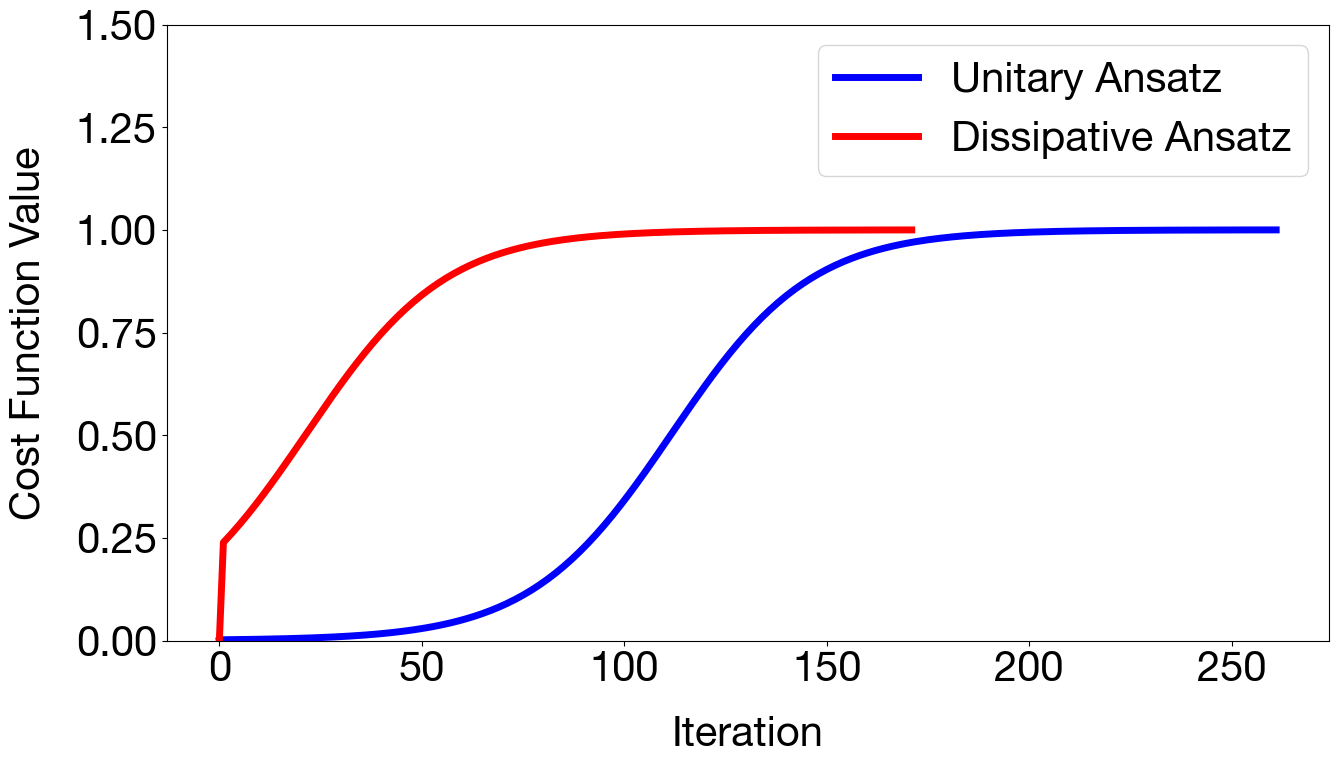

In [7]:
iterations_unitary = np.arange(len(cost_history_unitary))
iterations_dissipative = np.arange(len(cost_history_dissipative))

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(iterations_unitary[:len(cost_history_unitary)], cost_history_unitary, label='Unitary Ansatz', color='blue', linewidth=5)
plt.plot(iterations_dissipative[:len(cost_history_dissipative)], cost_history_dissipative, label='Dissipative Ansatz', color='red', linewidth=5)
plt.xlabel('Iteration', labelpad=20)
plt.ylabel('Cost Function Value', labelpad=20)
plt.legend()
plt.ylim([0, 1.5])
# plt.savefig('cost_function_unitary_dissipative_' + str(n_layers) + '.png', dpi=600, bbox_inches='tight')
plt.show()

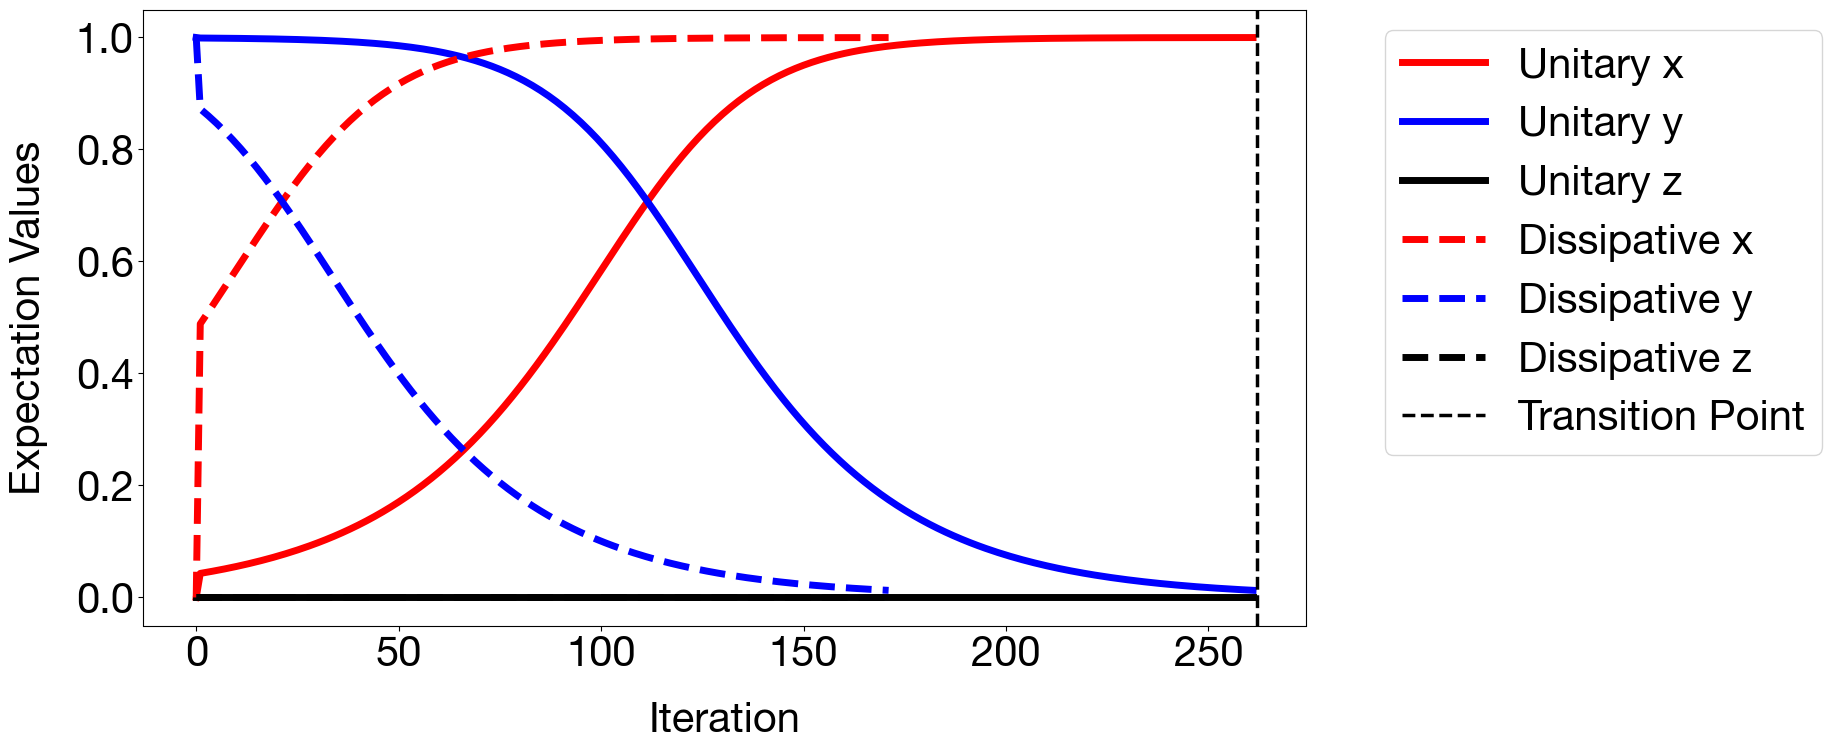

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(iterations_unitary, x_history_unitary, label='Unitary x', color='red', linewidth=5, linestyle='-')
plt.plot(iterations_unitary, y_history_unitary, label='Unitary y', color='blue', linewidth=5, linestyle='-')
plt.plot(iterations_unitary, z_history_unitary, label='Unitary z', color='k', linewidth=5, linestyle='-')
plt.plot(iterations_dissipative, x_history_dissipative, label='Dissipative x', color='red', linewidth=5, linestyle='--')
plt.plot(iterations_dissipative, y_history_dissipative, label='Dissipative y', color='blue', linewidth=5, linestyle='--')
plt.plot(iterations_dissipative, z_history_dissipative, label='Dissipative z', color='k', linewidth=5, linestyle='--')
# plt.plot(iterations[:len(x_history_unitary)], x_history_unitary**2 + y_history_unitary**2 + z_history_unitary**2, label='Unitary (Norm)', color='green', linewidth=2, linestyle='-.')
# plt.plot(iterations[len(x_history_unitary):], np.array(x_history_dissipative)**2 + np.array(y_history_dissipative)**2 + np.array(z_history_dissipative)**2, label='Dissipative (Norm)', color='brown', linewidth=2, linestyle='-.')
plt.axvline(x=len(x_history_unitary), color='black', linestyle='--', label='Transition Point', linewidth=2.5)
plt.xlabel('Iteration', labelpad=20)
plt.ylabel('Expectation Values', labelpad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

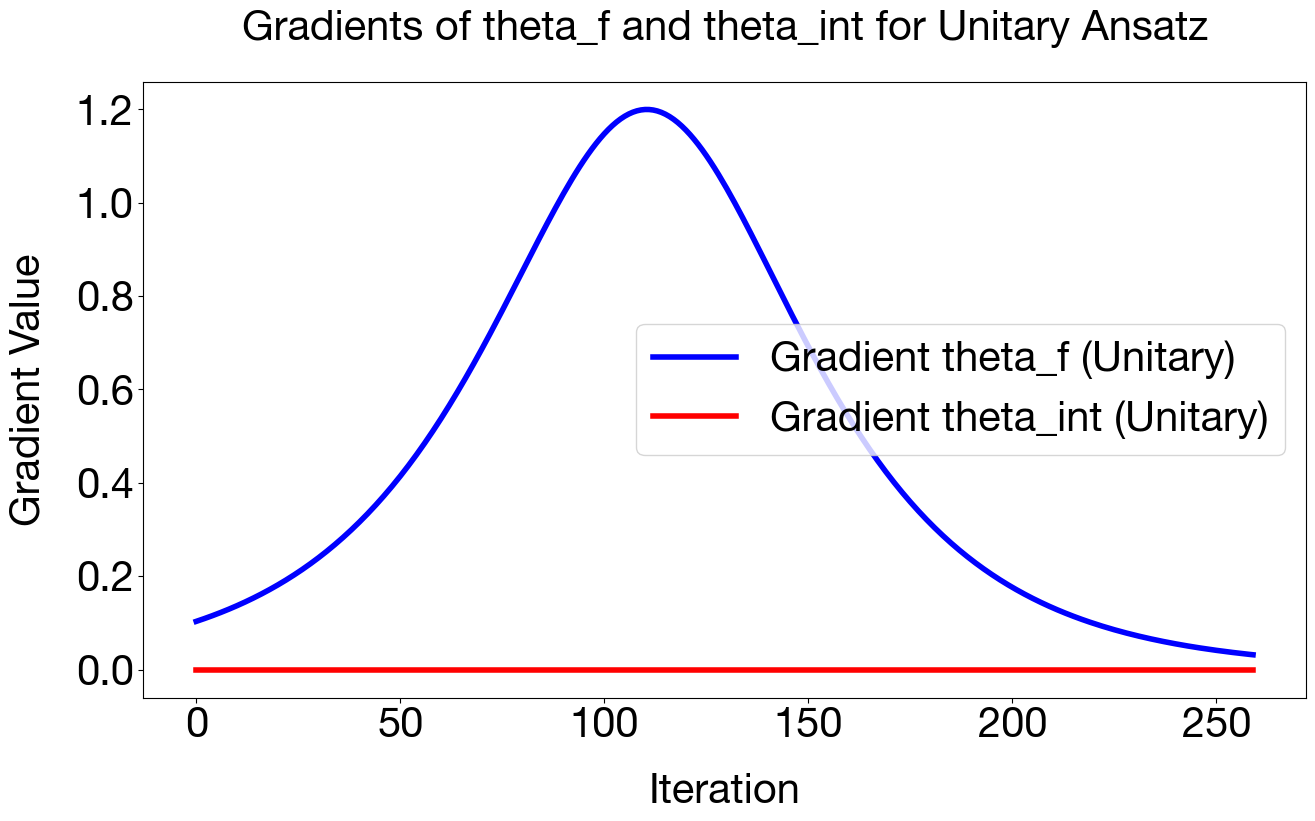

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
gradients_unitary = np.array(gradients_history_unitary)
n = min(len(iterations_unitary), len(gradients_unitary))
plt.plot(iterations_unitary[:n], gradients_unitary[:n, 0, 0], label='Gradient theta_f (Unitary)', color='blue', linewidth=4)
plt.plot(iterations_unitary[:n], gradients_unitary[:n, 0, 2], label='Gradient theta_int (Unitary)', color='red', linewidth=4)
plt.xlabel('Iteration', labelpad=20)
plt.ylabel('Gradient Value', labelpad=20)
plt.legend()
plt.title('Gradients of theta_f and theta_int for Unitary Ansatz')
plt.show()

In [ ]:
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/jupyter_data/'
# os.chdir(path)

# # Layer = 2
# vqe_results_unitary_2 = np.load('vqe_results_unitary.npz', allow_pickle=True)
# gradients_history_unitary_2 = vqe_results_unitary_2['gradients_history']
# vqe_results_dissipative_2 = np.load('vqe_results_dissipative.npz', allow_pickle=True)
# gradients_history_dissipative_2 = vqe_results_dissipative_2['gradients_history']
# hessian_diag_history_dissipative_2 = vqe_results_dissipative_2['hessian_diag_history']

# # Layer = 3
# vqe_results_unitary_3 = np.load('vqe_results_unitary_3.npz', allow_pickle=True)
# gradients_history_unitary_3 = vqe_results_unitary_3['gradients_history']
# vqe_results_dissipative_3 = np.load('vqe_results_dissipative_3.npz', allow_pickle=True)
# gradients_history_dissipative_3 = vqe_results_dissipative_3['gradients_history']
# hessian_diag_history_dissipative_3 = vqe_results_dissipative_3['hessian_diag_history']

# # Layer = 4
# vqe_results_unitary_4 = np.load('vqe_results_unitary_4.npz', allow_pickle=True)
# gradients_history_unitary_4 = vqe_results_unitary_4['gradients_history']
# vqe_results_dissipative_4 = np.load('vqe_results_dissipative_4.npz', allow_pickle=True)
# gradients_history_dissipative_4 = vqe_results_dissipative_4['gradients_history']
# hessian_diag_history_dissipative_4 = vqe_results_dissipative_4['hessian_diag_history']

# # Layer = 5
# vqe_results_unitary_5 = np.load('vqe_results_unitary_5.npz', allow_pickle=True)
# gradients_history_unitary_5 = vqe_results_unitary_5['gradients_history']
# vqe_results_dissipative_5 = np.load('vqe_results_dissipative_5.npz', allow_pickle=True)
# gradients_history_dissipative_5 = vqe_results_dissipative_5['gradients_history']
# hessian_diag_history_dissipative_5 = vqe_results_dissipative_5['hessian_diag_history']

# # Layer = 6
# vqe_results_unitary_6 = np.load('vqe_results_unitary_6.npz', allow_pickle=True)
# gradients_history_unitary_6 = vqe_results_unitary_6['gradients_history']
# vqe_results_dissipative_6 = np.load('vqe_results_dissipative_6.npz', allow_pickle=True)
# gradients_history_dissipative_6 = vqe_results_dissipative_6['gradients_history']
# hessian_diag_history_dissipative_6 = vqe_results_dissipative_6['hessian_diag_history']

# gradient_unitary_variance_2 = np.mean(np.var(np.array(gradients_history_unitary_2), axis=0), axis = 0)
# gradient_dissipative_variance_2 = np.mean(np.var(np.array(gradients_history_dissipative_2), axis=0), axis = 0)
# gradient_unitary_variance_3 = np.mean(np.var(np.array(gradients_history_unitary_3), axis=0), axis = 0)
# gradient_dissipative_variance_3 = np.mean(np.var(np.array(gradients_history_dissipative_3), axis=0), axis = 0)
# gradient_unitary_variance_4 = np.mean(np.var(np.array(gradients_history_unitary_4), axis=0), axis = 0)
# gradient_dissipative_variance_4 = np.mean(np.var(np.array(gradients_history_dissipative_4), axis=0), axis = 0)
# gradient_unitary_variance_5 = np.mean(np.var(np.array(gradients_history_unitary_5), axis=0), axis = 0)
# gradient_dissipative_variance_5 = np.mean(np.var(np.array(gradients_history_dissipative_5), axis=0), axis = 0)
# gradient_unitary_variance_6 = np.mean(np.var(np.array(gradients_history_unitary_6), axis=0), axis = 0)
# gradient_dissipative_variance_6 = np.mean(np.var(np.array(gradients_history_dissipative_6), axis=0), axis = 0)

# hessian_unitary_variance_2 = np.mean(np.var(np.array(hessian_diag_history_dissipative_2), axis=0), axis = 0)
# hessian_unitary_variance_3 = np.mean(np.var(np.array(hessian_diag_history_dissipative_3), axis=0), axis = 0)
# hessian_unitary_variance_4 = np.mean(np.var(np.array(hessian_diag_history_dissipative_4), axis=0), axis = 0)
# hessian_unitary_variance_5 = np.mean(np.var(np.array(hessian_diag_history_dissipative_5), axis=0), axis = 0)
# hessian_unitary_variance_6 = np.mean(np.var(np.array(hessian_diag_history_dissipative_6), axis=0), axis = 0)
# hessian_dissipative_variance_2 = np.mean(np.var(np.array(hessian_diag_history_dissipative_2), axis=0), axis = 0)
# hessian_dissipative_variance_3 = np.mean(np.var(np.array(hessian_diag_history_dissipative_3), axis=0), axis = 0)
# hessian_dissipative_variance_4 = np.mean(np.var(np.array(hessian_diag_history_dissipative_4), axis=0), axis = 0)
# hessian_dissipative_variance_5 = np.mean(np.var(np.array(hessian_diag_history_dissipative_5), axis=0), axis = 0)
# hessian_dissipative_variance_6 = np.mean(np.var(np.array(hessian_diag_history_dissipative_6), axis=0), axis = 0)

In [ ]:
# gradient_unitary_variance_lst = [gradient_unitary_variance_2, gradient_unitary_variance_3, gradient_unitary_variance_4, gradient_unitary_variance_5, gradient_unitary_variance_6]
# gradient_dissipative_variance_lst = [gradient_dissipative_variance_2, gradient_dissipative_variance_3, gradient_dissipative_variance_4, gradient_dissipative_variance_5, gradient_dissipative_variance_6]
# layers = [2, 3, 4, 5, 6]

# fig, ax = plt.subplots(figsize=(10, 8))
# plt.plot(layers, gradient_unitary_variance_lst, label='Unitary Ansatz', color='blue', marker='o', linewidth=5, markersize=15)
# plt.plot(layers, gradient_dissipative_variance_lst, label='Dissipative Ansatz', color='red', marker='o', linewidth=5, markersize=15)
# plt.yscale('log')
# plt.xlabel('Number of Layers', labelpad=20)
# plt.ylabel('Average Gradient Variance', labelpad=20)
# plt.xticks(layers)
# # Legend outside the plot
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()